100% |██████████| [00:00<00:00, 159.85%/s]


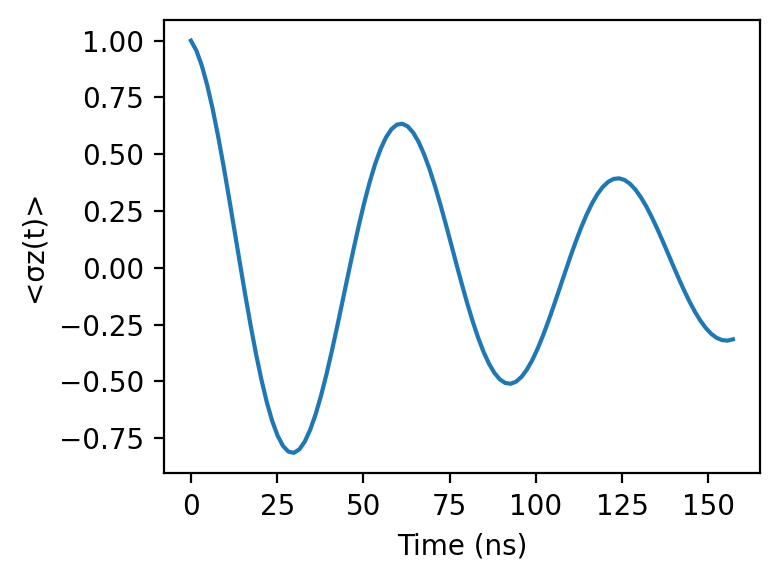

In [1]:
from jax import jit
import jaxquantum as jqt
import jax.numpy as jnp
import matplotlib.pyplot as plt

omega_q = 5.0 #GHzz
Omega = .1
g_state = jqt.basis(2,0) ^ jqt.basis(2,0)
g_state_dm = g_state.to_dm()

ts = jnp.linspace(0,5*jnp.pi/Omega,101)
c_ops = jqt.Qarray.from_list([0.1*jqt.sigmam()^jqt.identity(N=2)])

sz0 = jqt.sigmaz() ^ jqt.identity(N=2)

@jit
def Ht(t):
    H0 = omega_q/2.0*((jqt.sigmaz()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmaz()))
    H1 = Omega*jnp.cos((omega_q)*t)*((jqt.sigmax()^jqt.identity(N=2)) + (jqt.identity(N=2)^jqt.sigmax()))
    return H0 + H1

solver_options = jqt.SolverOptions.create(progress_meter=True)
states = jqt.mesolve(Ht, g_state_dm, ts, c_ops=c_ops, solver_options=solver_options) 
szt = jnp.real(jqt.overlap(sz0, states))


fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

# Schroedinger's Equation

In [3]:
%timeit -n1 -r1 jqt.sesolve(Ht, g_state, ts).data.block_until_ready()
%timeit jqt.sesolve(Ht, g_state, ts).data.block_until_ready()

100% |██████████| [00:00<00:00, 1467.29%/s]


810 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


100% |██████████| [00:00<00:00, 1494.83%/s]
100% |██████████| [00:00<00:00, 1510.62%/s]
100% |██████████| [00:00<00:00, 1524.27%/s]
100% |██████████| [00:00<00:00, 1463.48%/s]
100% |██████████| [00:00<00:00, 1402.78%/s]
100% |██████████| [00:00<00:00, 1419.19%/s]
100% |██████████| [00:00<00:00, 1476.78%/s]
100% |██████████| [00:00<00:00, 1365.93%/s]

799 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
states = jqt.sesolve(Ht, g_state, ts) 

100% |██████████| [00:00<00:00, 1597.54%/s]


In [5]:
szt = jnp.real(jqt.overlap(states, sz0))

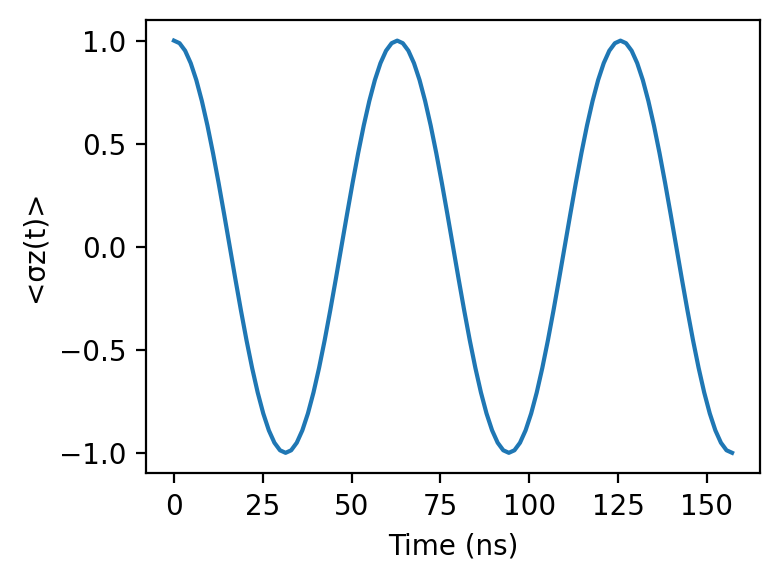

In [6]:
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

# Master Equation in Lindbladian Form

In [5]:
%timeit -n1 -r1 jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 
%timeit jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 

37.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
34.7 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
states = jqt.mesolve(g_state_dm, ts, c_ops=c_ops, Ht=Ht) 
szt = jnp.real(jqt.calc_expect(sz0, states))

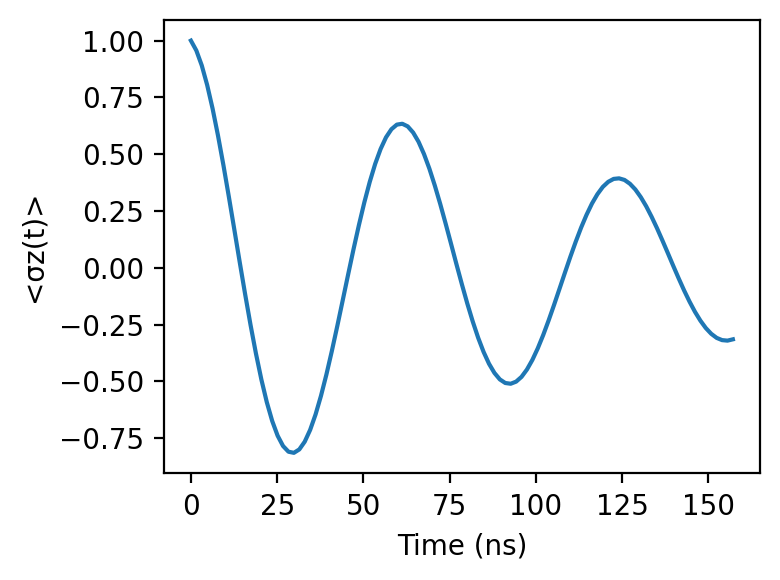

In [7]:
fig, ax = plt.subplots(1, dpi=200, figsize=(4,3))
ax.plot(ts, szt)
ax.set_xlabel("Time (ns)")
ax.set_ylabel("<σz(t)>")
fig.tight_layout()

# Auto-Diff

In [8]:
from jax import grad

@jit
def test_grad(a):
    states = jqt.mesolve(g_state_dm, ts*a, c_ops=c_ops, Ht=Ht) 
    return jnp.real(states[-1].data[0,0])

%timeit -n1 -r1 grad(test_grad)(1.0)
%timeit grad(test_grad)(1.0)

3.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
181 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
